In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import os
import logging
import time

In [2]:
#os.chdir('..')
os.chdir('C:/Users/BC966HL/OneDrive - EY/4. Mestrado/Dev/')
os.getcwd()

'C:\\Users\\BC966HL\\OneDrive - EY\\4. Mestrado\\Dev'

In [3]:
from Coding.etl.data_normalization import data_norm
from Coding.etl.input_parameters import (recipe_def, create_cost_column, input_lots, target_volume, model_files)
from Coding.model.minimize import (model_input_read, constraints_bounds, cost_obj_f, minimize_round, simulation_fixed_x0_var_iterations, simulation_var_x0_fixed_iterations, model_results)

In [4]:
# Reading CQI CSV file as input, normalizing data and creating cleaned_cqi_file.csv with no-NaN rows and consistent coffee sample parameters
data_norm()

# recipe_def function to read the cleaned_cqi_file.csv and extract a random row to be used as target for the model. It will return a single row dataframe with unusable LOT_AVAILABILITY_KG field and the normalized dataframe with the selected row removed
df_recipe, df_norm = recipe_def()

# create_cost_column gets the normalized dataframe without the recipe row and create a random cost per kg in BRL to the lot on the row, the model will seek to minimize this final cost attending to the other parameters
df_norm_cost = create_cost_column(df_norm)

# input_lots will get the normalized dataframe without the recipe row and with the cost column and extracts from the n available rows a lot_limit (default = 10) sized dataframe which will be used as available lots to the model work on
df_lots_available = input_lots(df_norm_cost, return_df_norm_wout_lots = False, lot_limit = 10)

# df_recipe_volume simulate the batch volume
# if simulate_broken_volume is set to True, it will create a volume higher than the available lots can provide together, reaching from the volume sum to broken_perc*volume sum, the broken_perc is set to 1.5 as default
# if is set to False, will get from the lots available volume sum * low_perc to volume sum * high perc, which are set as default to 0.2 and 0.8 respectively
df_recipe_volume = target_volume(df_recipe, df_lots_available, simulate_broken_volume = False)

# model_files export the recipe and available lots datasets to /Datasets/model as input_recipe.csv and input_lots_available.csv with ';' as CSV separator
model_files(df_recipe_volume, df_lots_available)

In [5]:
df_recipe, df_available_lots = model_input_read()

#constraints, bnd = constraints_bounds(df_recipe, df_available_lots, ub = 0.7)

In [19]:
simulation_fx_x0_var_iter = simulation_fixed_x0_var_iterations(df_recipe, df_available_lots, ub = 0.7, stop = 1000, step = 10)
simulation_var_x0_fx_iter = simulation_var_x0_fixed_iterations(df_recipe, df_available_lots, iterations = 10, model_maxiter = 100)

In [40]:
test_df = pd.DataFrame(simulation_fx_x0_var_iter).transpose()

In [41]:
test_df['maxiter'] = test_df.index.astype(int) + 1

In [42]:
nit_list = []
status_list = []
fun_list = []
time_list = []
for i in range(len(test_df['maxiter'])):
    nit_list.append(test_df[0][i].nit)
    status_list.append(test_df[0][i].status)
    fun_list.append(test_df[0][i].fun)
    time_list.append(test_df[1][i]['extra_data']['round_time'])

In [43]:
test_df['nit'] = nit_list
test_df['status'] = status_list
test_df['residuo'] = fun_list
test_df['round_time'] = time_list

In [44]:
test_df = test_df[test_df['status'] == 0]

In [45]:
import matplotlib.pyplot as plt

In [51]:
test_df = pd.DataFrame(test_df.groupby(by = 'nit').mean())
test_df['nit'] = test_df.index

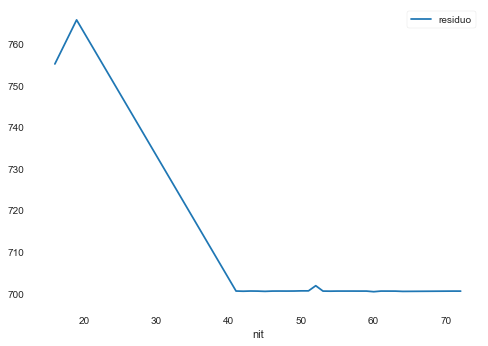

In [57]:
test_df.plot(x='nit', y=['residuo'])

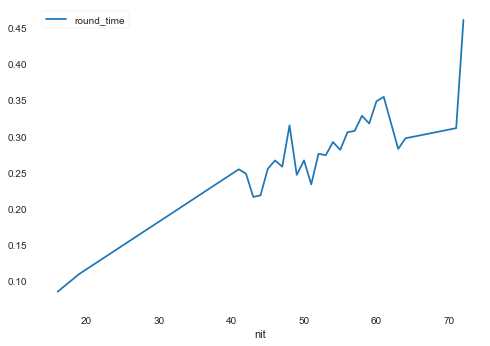

In [54]:
test_df.plot(x='nit', y=['round_time'])